## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
str = "";
for i in range(len(text)):
    str = str + text[i]

text = str.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2020-05-26 11:45:29--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.05s   

2020-05-26 11:45:30 (4.88 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
tmp = []
for i in range(0, len(text)):
    tmp.append(text[i].lower())

text = tmp

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
import re
parts = re.split('\n\n\s*[a-z]*\n\n', text)

In [ ]:
tokens = sorted(set(text))
print(tokens)

print(len(tokens))

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
token_to_idx = {}
idx_to_token = {}

for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i;
    idx_to_token[i] = tokens[i];
    
num_tokens = len(tokens)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [ ]:
def to_matrix(parts, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    max_len = max_len or max(map(len, parts))
    parts_ix = np.zeros([len(parts), max_len], dtype) + pad

    for i in range(len(parts)):
        line_ix = [token_to_idx[c] for c in parts[i]]
        parts_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        parts_ix = np.transpose(names_ix)

    return parts_ix

In [ ]:
batch_ix = to_matrix(parts[:5])
print(batch_ix)

[[ 1  1 17 ...  1  1  1]
 [ 1  1 34 ... 23 15  8]
 [ 1  1 23 ...  1  1  1]
 [ 1  1 32 ...  1  1  1]
 [ 1  1 31 ...  1  1  1]]


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
      
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
from IPython.display import clear_output
from random import sample
import time

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

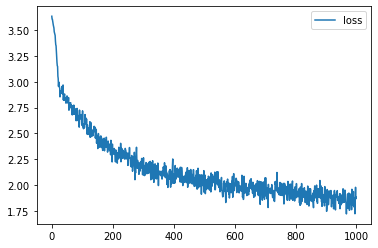

In [ ]:
for i in range(1000):
    batch_ix = to_matrix(sample(parts, 2))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
    

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
MAX_LENGTH = 1000

In [ ]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(4):
    print(generate_sample(char_rnn, "when", temperature=0.8))
    print('\n\n')

when,
  that shou ler, not that wild yound of theb manon cumbll our andnes i lit thy ap on and the stith, agant wily wore mine ove of wace pell i have of i   is thy mive plete trem and thou mat wo meauturss mast owe tho stou beright thom all, mare,
  on my mair dilferen treft ow thou peisfond be thew my sederen grapy,
  fon apon to moll ppere im qeaed tient;
  thll aut woufes     rath rape of andrens astet fyat sume cosk endellon fme pold yis stalf sume thy be love wimed.
  shit prele,
  worth
  the othse to demine of thy mesppraigt;
  math sisteich thouls trit the  do maktis thy store that reirt gnale hould yar cains anjend a lose, wout'd with serthon soous cowlon
  bree berape, shem  to mose which thou and on the pedadie thee that bete owe,
    an for prave, whame,
  and thee of my my my least so pperstilt all, than hat me thin ono, and the so of that shad donder tore and the hath eaclire hare campy coce doth my houst,
  the ppon for eloves bredsrt's and maen i hove the tine gor the 

Получился текст, весьма осмысленный в некотором смысле. Моя модель научилась расставлять запятые и делать адекватные соннеты. Однако, моделе не хватает словарного запаса.

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [ ]:
rimlian_nums = ['i', 'ii', 'iii', 'il', 'v', 'iv', 'l', 'li', 'lii', 'liii', 'liv', 'lv', 'lvi', 'lvii', 'lviii', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xix', 'xl', 'xli', 'xlii', 'xliii', 'xliv', 'xlix', 'xlv', 'xlvi', 'xlvii', 'xlviii', 'xv', 'xvi', 'xvii', 'xviii', 'xx', 'xxi', 'xxii', 'xxiii', 'xxiv', 'xxix', 'xxv', 'xxvi', 'xxvii', 'xxviii', 'xxx', 'xxxi', 'xxxii', 'xxxiii', 'xxxiv', 'xxxix', 'xxxv', 'xxxvi', 'xxxvii', 'xxxviii']

Римские цифры набирала не вручную, а просто скопировала из токенов

In [ ]:
tmp = []
for i in range(0, len(text)):
    out = text[i]

    out = out.replace('(', ' ').replace(')', ' ').replace('77', ' ').replace('78', ' ').replace('79', ' ')
    out = out.replace(';', ' ').replace('«', ' ').replace('»', ' ')
    out = out.replace('!', ' ').replace('?', ' ').replace(':', ' ')
    out = out.replace('-', ' ').replace('[', ' ').replace(']', ' ') 

    for t in rimlian_nums:
        out = out.replace(t, ' ')

    tmp.append(out)

text = tmp

In [ ]:
tmp = []
for i in range(0, len(text)):
    out = text[i]
    if out[0] != '\n':
        tmp.append(out)

print(text)

In [ ]:
punkt = []
punkt.append('.')
punkt.append(',')
#punkt.append(' ')

In [ ]:
tmp = []
for i in range(0, len(text)-2):
    out = text[i]
    out = out[0:(len(out)-1)]
    for i in range(0, len(out)):
        if len(out) == 1:
            break
        for j in punkt:
            if j == out[i]:
                if i != 1 and out[i-1] == ' ':
                    continue
                out = out[:i] + " " + out[i:]
                i -= 1

    out = out + " " + "\n"

    tmp.append(out)

text = tmp


max length = 160


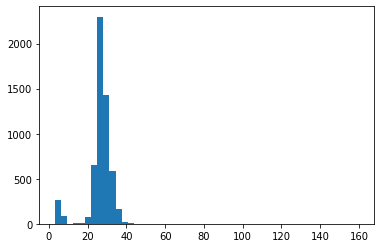

In [ ]:
import matplotlib.pyplot as plt

MAX_LENGTH = max(map(len, text))
print("max length =", MAX_LENGTH)

plt.hist(list(map(len, text)),bins=50);

Удалим предложения с длинной больше чем 40, та как такие предложения редко встречаются. 

In [ ]:
tmp = []
for i in range(0, len(text)):
    if len(text[i]) < 40:
        tmp.append(text[i])

text = tmp  

max length = 39


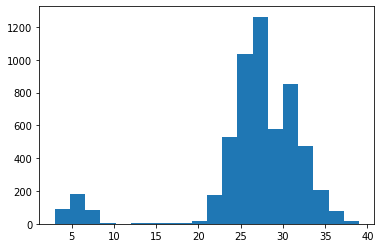

In [ ]:
MAX_LENGTH = max(map(len, text))
print("max length =", MAX_LENGTH)

plt.hist(list(map(len, text)),bins=20);

In [ ]:
str = "";
for i in range(len(text)):
    str = str + text[i]

out = str.lower()

In [ ]:
x = out.split()

In [ ]:
tokens = sorted(set(x))


tokens.append('\n')
tokens.append(' ')

print(len(tokens))

In [ ]:
token_to_idx = {}
idx_to_token = {}

for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i;
    idx_to_token[i] = tokens[i];

In [ ]:
def to_matrix(str, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of str into rnn-digestable matrix"""
    
    names_ix = np.zeros([len(str), max_len], dtype) + pad
    for i in range(0, len(str)):
        names_ix[i][max_len-1] = token_to_idx['\n']
    
    for i in range(len(str)):
        inp = str[i]
        inp = inp.split()
        tmp = []
        for j in range(len(inp)):
            line_ix = [token_to_idx[c] for c in inp]
            names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(len(tokens), emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, len(tokens))
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [ ]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

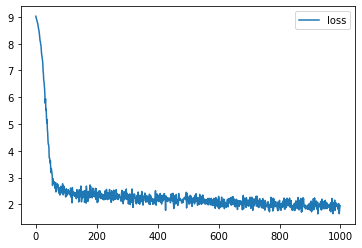

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, len(tokens)),
        actual_next_tokens.contiguous().view(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    #seed_phrase = seed_phrase.split(' ')
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next = char_rnn(x_sequence[:, None,-1,])
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(len(tokens),p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] + ' ' for ix in x_sequence.data.numpy()[0]]) 

In [ ]:
for _ in range(10):
    print(generate_sample(model, temperature=3, max_length=5))

  пышный оли нравилась… рак 
  клавикорды ступить изумленьем двоюродный 
  находила начала благословить величавый 
  мадригальных косматой мельницу луг 
  подвинь смятом скорей граненый 
  утраты самое ступает молчанье 
  скоро любовь, скончался углублен 
  пустой. мглу молвь мысль 
  встретить северное бранит зарецкий 
  тройке трачу бьются взываю 


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
temperatura = [0.1, 0.2, 0.5, 1.0, 2.0]

for i in range(0, len(temperatura)):
    print("Temperature: ", temperatura[i])

    for _ in range(10):
        print(generate_sample(model, temperature=temperatura[i], max_length=6))

    print("\n")

Temperature:  0.1
            
            
            
            
            
            
            
            
            
            


Temperature:  0.2
            
            
            
      
   
 
            
          
 
            
    
 и , , 
            
            


Temperature:  0.5
  
 мир мой всечасно в 
        
 может 
          
 
  
 где целыми евгенья бурных 
      
 в ново 
  
 ученым улыбки черти плеча… 
  
 томленье , где желал 
  
 в чертог   
 
    
 страстью угас , 
            


Temperature:  1.0
  одна был мощны подушкою вспыхнул 
  вновь том постеле журналы, тазы 
    ленского друга охнет дианы 
  , te^te себялюбивой   . 
    
 дев повернула онегина 
  ногти лицами подшутил трещат думал 
  
 эти мечтательницы удовольствием требуют 
  сук открыла младое очарован томною 
      торжественные приходит прелестных 
  
 всё она томил упрямые 


Temperature:  2.0
  начитаться приветствий злую вырваться ощущений 
  замечает угрозы, новых поклон

Для мой модели видно, что при низком показателе `temeprature` пробелы - это наиболее вероятный выход. Если повышать меру хауса, то видно, что в поэме появляется все больше и больше слов, причем складывается ощущение, что при максимальной `temeprature` генератор выдает много редких слов.



### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
def save_checkpoint(checkpoint_path, model):
    state = {
        'state_dict': model.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
save_checkpoint('LSTM.pth', model)
save_checkpoint('vanilla_RNN.pth', char_rnn)

In [ ]:
m = CharRNNCell()

load_checkpoint('vanilla_RNN.pth', m)

model loaded from vanilla_RNN.pth


In [ ]:
m1 = CharRNNLoop()

load_checkpoint('LSTM.pth', m1)

In [ ]:
print(generate_sample(m, temperature=0.8))

 muns the and is froster to sers nive seeste plort,
  of till beien wo trens toth eine do in oum pand and the thou the bsere the call tomen,
  whise hrees the rand reth bus laven .en more iast heart wo lome priose gor magll'd of for ase for meen in beniflos batound pull, with iy sernen'd frow i cuiser for thin age thou trach not thee daply;
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)